In [2]:
from math import sqrt

import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
import pyro
import pyro.distributions as dist
import zuko
import numpy as np
from tqdm import tqdm
import IPython
from IPython.display import HTML

%matplotlib widget
sns.set(style="white", context="notebook", palette="deep", color_codes=True)

Changing lane at time 45  new lane 1.0
Changing lane at time 52  new lane 0.0
Changing lane at time 57  new lane 1.0


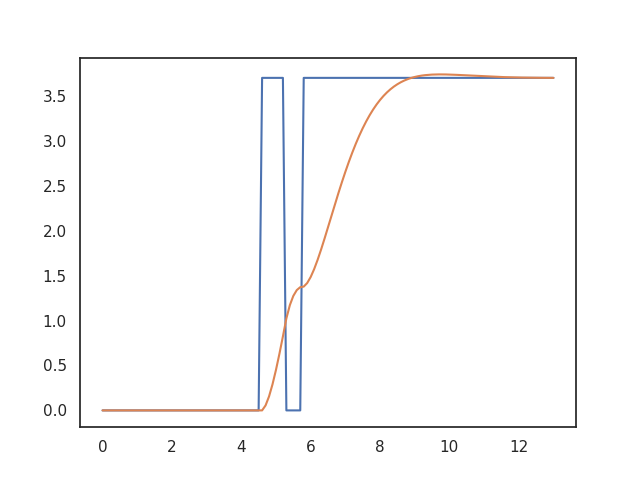

In [8]:
# Implement the AV models (thanks ChatGPT)


class IDMModel(torch.nn.Module):
    def __init__(
        self,
        max_acceleration,
        desired_velocity,
        min_spacing,
        time_headway,
        delta,
    ):
        super(IDMModel, self).__init__()
        self.max_acceleration = max_acceleration
        self.desired_velocity = desired_velocity
        self.min_spacing = min_spacing
        self.time_headway = time_headway
        self.delta = delta

    def forward(self, velocity, lead_velocity, spacing):
        # Desired gap
        desired_gap = (
            self.min_spacing
            + velocity * self.time_headway
            + (velocity * (velocity - lead_velocity))
            / (2 * sqrt(self.max_acceleration * self.max_acceleration))
        )
        # Acceleration
        acceleration = self.max_acceleration * (
            1
            - torch.pow((velocity / self.desired_velocity), self.delta)
            - (desired_gap / spacing) ** 2
        )
        return acceleration


class MOBILModel(torch.nn.Module):
    def __init__(self, politeness_factor, threshold_acceleration, safe_acceleration):
        super(MOBILModel, self).__init__()
        self.politeness_factor = politeness_factor
        self.threshold_acceleration = threshold_acceleration
        self.safe_acceleration = safe_acceleration

    def forward(
        self,
        current_acceleration,
        new_acceleration,
        following_acceleration,
        new_following_acceleration,
    ):
        # Incentive criterion
        incentive_criterion = (
            new_acceleration - current_acceleration - self.threshold_acceleration
        )

        # Safety criterion
        safety_criterion = new_following_acceleration + self.safe_acceleration

        # Politeness criterion
        politeness_criterion = self.politeness_factor * (
            new_following_acceleration - following_acceleration
        ) + (new_acceleration - current_acceleration)

        # Compute a probability that goes to 1 when all criteria are met
        lane_switch_probability = (
            torch.sigmoid(incentive_criterion)
            * torch.sigmoid(safety_criterion)
            * torch.sigmoid(politeness_criterion)
        )
        lane_switch_probability = (
            1.0
            if incentive_criterion > 0
            and safety_criterion > 0
            and politeness_criterion > 0
            else 0.0
        )

        return lane_switch_probability


def simulate(T=100, dt=0.1):
    """Simulate a car using the IDM and MOBIL decision models."""
    # Scene parameters
    lane_width = 3.7  # meters
    speed_limit = 10.0  # meters per second
    car_length = 4.0  # meters

    # Convenience for state indicies
    PX, PY, VX, VY, LANE = 0, 1, 2, 3, 4

    # Set the initial states of all cars in the simulation
    # [p_x, p_y, v_x, v_y, desired_lane]
    ego_state = torch.tensor([10.0, 0.0, speed_limit, 0.0, 0.0])
    non_ego_states = torch.tensor(
        [
            [-10.0, lane_width, 1.1 * speed_limit, 0.0, 1.0],
            [20.0, lane_width, 0.9 * speed_limit, 0.0, 1.0],
            [20.0, 0.0, 0.7 * speed_limit, 0.0, 0.0],
        ]
    )

    # Create the IDM and MOBIL models
    idm = IDMModel(
        max_acceleration=2.0,
        desired_velocity=speed_limit,
        min_spacing=1.0,
        time_headway=1.0,
        delta=4,
    )
    mobil = MOBILModel(
        politeness_factor=0.0, threshold_acceleration=0.2, safe_acceleration=0.5
    )

    # Simulate the scene
    ego_state_trace = [ego_state]
    non_ego_states_trace = [non_ego_states]
    num_steps = int(T / dt)

    for t in range(num_steps):
        # Get the current state of the ego vehicle
        ego_state = ego_state_trace[-1]

        # Get the current states of the non-ego vehicles
        non_ego_states = non_ego_states_trace[-1]

        # Get the vehicle in front of the ego vehicle in both its lane and the other
        # lane
        leading_vehicle_in_lane = None
        leading_vehicle_in_other_lane = None
        for non_ego_state in non_ego_states:
            # It's not leading if it's behind us
            if non_ego_state[PX] < ego_state[PX]:
                continue

            # Check if it's leading in our lane (leading = closest to ego vehicle)
            if non_ego_state[LANE] == ego_state[LANE]:
                if leading_vehicle_in_lane is None:
                    leading_vehicle_in_lane = non_ego_state
                elif non_ego_state[PX] < leading_vehicle_in_lane[PX]:
                    leading_vehicle_in_lane = non_ego_state
            else:
                if leading_vehicle_in_other_lane is None:
                    leading_vehicle_in_other_lane = non_ego_state
                elif non_ego_state[PX] < leading_vehicle_in_other_lane[PX]:
                    leading_vehicle_in_other_lane = non_ego_state

        # Get the vehicle behind the ego vehicle in the other lane
        following_vehicle_in_other_lane = None
        for non_ego_state in non_ego_states:
            # It's not following if it's in front of us
            if non_ego_state[PX] > ego_state[PX]:
                continue

            # Check if it's following in the other lane (following = closest to ego
            # vehicle)
            if non_ego_state[LANE] != ego_state[LANE]:
                if following_vehicle_in_other_lane is None:
                    following_vehicle_in_other_lane = non_ego_state
                elif non_ego_state[PX] > following_vehicle_in_other_lane[PX]:
                    following_vehicle_in_other_lane = non_ego_state

        # Get the acceleration of the ego vehicle both in the current lane and
        # the other lane (if we were to switch)
        current_acceleration = idm(
            ego_state[VX],
            leading_vehicle_in_lane[VX]
            if leading_vehicle_in_lane is not None
            else ego_state[VX],
            leading_vehicle_in_lane[PX] - ego_state[PX] - car_length
            if leading_vehicle_in_lane is not None
            else 20.0,
        )
        new_acceleration = idm(
            ego_state[VX],
            leading_vehicle_in_other_lane[VX]
            if leading_vehicle_in_other_lane is not None
            else ego_state[VX],
            leading_vehicle_in_other_lane[PX] - ego_state[PX] - car_length
            if leading_vehicle_in_other_lane is not None
            else 20.0,
        )

        # Get the acceleration of the vehicle behind the ego vehicle in the other
        # lane (if we were to switch)
        following_acceleration = torch.tensor(0.0)
        if following_vehicle_in_other_lane is not None:
            following_acceleration = idm(
                following_vehicle_in_other_lane[VX],
                ego_state[VX],
                ego_state[PX] - following_vehicle_in_other_lane[PX] - car_length,
            )

        # Get the lane switching probability
        lane_change_probability = mobil(
            current_acceleration,
            new_acceleration,
            following_acceleration,
            following_acceleration,
        )
        lane_change = pyro.sample(
            f"lane_change_{t}",
            dist.Bernoulli(lane_change_probability),
        )
        new_lane = (
            ego_state[LANE] * (1 - lane_change) + (1 - ego_state[LANE]) * lane_change
        )
        acceleration = (
            current_acceleration * (1 - lane_change) + new_acceleration * lane_change
        )

        if lane_change:
            print("Changing lane at time", t, " new lane", new_lane.item())

        # Update ego dynamics, using a low-level controller to track the desired lane
        # and speed
        lane_error = ego_state[PY] - new_lane * lane_width
        new_ego_state = torch.tensor(
            [
                ego_state[PX] + ego_state[VX] * dt,
                ego_state[PY] + ego_state[VY] * dt,
                ego_state[VX] + acceleration * dt,
                ego_state[VY] - 1.5 * lane_error * dt - 2.0 * ego_state[VY] * dt,
                new_lane,
            ]
        )

        # Update non-ego dynamics (assume no acceleration)
        new_non_ego_states = torch.zeros_like(non_ego_states)
        new_non_ego_states[:, PX] = non_ego_states[:, PX] + non_ego_states[:, VX] * dt
        new_non_ego_states[:, PY] = non_ego_states[:, PY] + non_ego_states[:, VY] * dt
        new_non_ego_states[:, VX] = non_ego_states[:, VX]
        new_non_ego_states[:, VY] = non_ego_states[:, VY]
        new_non_ego_states[:, LANE] = non_ego_states[:, LANE]

        # Update the scene
        ego_state_trace.append(new_ego_state)
        non_ego_states_trace.append(new_non_ego_states)

    # Return the simulation results
    return torch.stack(ego_state_trace), torch.stack(non_ego_states_trace)


T = 13
dt = 0.1
ego_states, non_ego_states = simulate(T, dt)
t = torch.arange(0, T + dt, dt)

plt.plot(t, non_ego_states[:, 0, 0], "--", label="Non-ego 0")
plt.plot(t, non_ego_states[:, 1, 0], "--", label="Non-ego 1")
plt.plot(t, non_ego_states[:, 2, 0], "-", label="Non-ego 2")

ego_in_lane1 = ego_states[:, 4] == 1
ego_in_lane0 = ego_states[:, 4] == 0
plt.plot(t[ego_in_lane0], ego_states[ego_in_lane0, 0], "k-", label="Ego")
plt.plot(t[ego_in_lane1], ego_states[ego_in_lane1, 0], "k--")
plt.legend()

plt.figure()
plt.plot(t, ego_states[:, 4] * 3.7, label="Ego lane")
plt.plot(t, ego_states[:, 1], label="y")

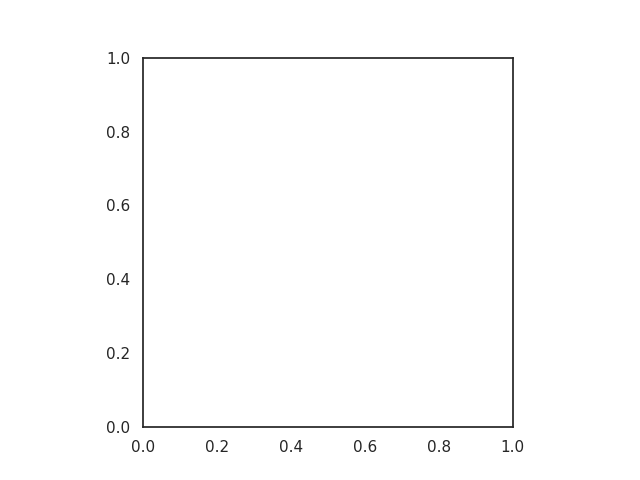

In [11]:
T, n, _ = non_ego_states.shape
fig, ax = plt.subplots()
ax.set_aspect("equal")
timestep = 0.1


def update(frame):
    ax.clear()
    ax.set_xlim(0, 150)  # Set appropriate limits for x-axis
    ax.set_ylim(-10, 10)  # Set appropriate limits for y-axis
    ax.axhline(y=0, color="k", linestyle="--")  # lane 0 centerline
    ax.axhline(y=3.7, color="k", linestyle="--")  # lane 1 centerline
    ax.set_title(f"Time: {frame * timestep:.2f} seconds")

    # Plot the ego car
    ego_x, ego_y = ego_states[frame, 0], ego_states[frame, 1]
    ax.plot(ego_x, ego_y, "ro", label="Ego Car")

    # Plot the non-ego cars
    for i in range(n):
        car_x, car_y = non_ego_states[frame, i, 0], non_ego_states[frame, i, 1]
        ax.plot(car_x, car_y, "bo", label="Non-Ego Car" if i == 0 else "")

    ax.legend()


ani = animation.FuncAnimation(
    fig, update, frames=T, interval=timestep * 1000, repeat=False
)
# HTML(ani.to_jshtml())